<a href="https://colab.research.google.com/github/vivek032001/Anime_GAN/blob/main/anime_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#inporting required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision
import os
import zipfile

In [ ]:
#extracting data
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/anime_d.zip', 'r') 
zip_ref.extractall('/tmp') 
zip_ref.close()

In [ ]:
data_dir = '/tmp/anime_d'

In [ ]:
#hyperparameters
noise_shape = 100
img_shape = 64
batch_size = 128
channel = 3
ngpu = 1
feature_map = 64

In [ ]:
#creating dataset
data = torchvision.datasets.ImageFolder(root = data_dir, transform = torchvision.transforms.Compose([
                                                                                                     torchvision.transforms.Resize(img_shape),
                                                                                                     torchvision.transforms.CenterCrop(img_shape),
                                                                                                     torchvision.transforms.ToTensor(),
                                                                                                     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                                                                     ]))

dataloader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle = True, num_workers = 2)

In [ ]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

In [ ]:
#generator
class generator(torch.nn.Module):
  def __init__(self, ngpu):
    super(generator, self).__init__()
    self.ngpu = ngpu
    self.main = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(noise_shape, feature_map * 8, kernel_size = 4, stride = 1, padding = 0, bias = False),
        torch.nn.BatchNorm2d(feature_map * 8),
        torch.nn.ReLU(True),
        torch.nn.ConvTranspose2d(feature_map * 8, feature_map * 4, kernel_size = 4, stride = 2, padding = 1, bias = False),
        torch.nn.BatchNorm2d(feature_map * 4),
        torch.nn.ReLU(True),
        torch.nn.ConvTranspose2d(feature_map * 4, feature_map * 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
        torch.nn.BatchNorm2d(feature_map * 2),
        torch.nn.ReLU(True),
        torch.nn.ConvTranspose2d(feature_map * 2, feature_map, kernel_size = 4, stride = 2, padding = 1, bias = False),
        torch.nn.BatchNorm2d(feature_map),
        torch.nn.ReLU(True),
        torch.nn.ConvTranspose2d(feature_map, channel, kernel_size = 4, stride = 2, padding = 1, bias = False),
        torch.nn.Tanh()
    )

  def forward(self, input):
    return self.main(input)

In [ ]:
#discriminator 
class discriminator(torch.nn.Module):
  def __init__(self, ngpu):
    super(discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = torch.nn.Sequential(
        torch.nn.Conv2d(channel, feature_map, kernel_size = 4, stride = 2, padding = 1, bias = False),
        torch.nn.LeakyReLU(0.2),
        torch.nn.Conv2d(feature_map, feature_map * 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
        torch.nn.BatchNorm2d(feature_map * 2),
        torch.nn.LeakyReLU(0.2),
        torch.nn.Conv2d(feature_map * 2, feature_map * 4, kernel_size = 4, stride = 2, padding = 1, bias = False),
        torch.nn.BatchNorm2d(feature_map * 4),
        torch.nn.LeakyReLU(0.2),
        torch.nn.Conv2d(feature_map * 4, feature_map * 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
        torch.nn.BatchNorm2d(feature_map * 8),
        torch.nn.LeakyReLU(0.2),
        torch.nn.Conv2d(feature_map * 8, 1, kernel_size = 4, stride = 2, padding = 0, bias = False),
        torch.nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)

In [ ]:
#function for initializing weights for generator and discriminator 
def initialize(model):
  classname = model.__class__.__name__
  if classname.find('Conv') != -1:
    torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(model.bias.data, 0)


In [ ]:
#creating generator
gen = generator(ngpu).to(device)
#initializing weights of generator
gen.apply(initialize)
gen

generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
#creating discriminator
dis = discriminator(ngpu).to(device)
#initializing weights of discriminator
dis.apply(initialize)
dis

discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
lr = 2e-4
beta1 = 0.5
epochs = 7
#initliazing BCE loss
criterion  = torch.nn.BCELoss()
fixed_noise = torch.randn(64, noise_shape, 1, 1).to(device)

In [ ]:
#setting up optimizers for generator and disciminator 
g_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta1, 0.999))
d_opt = torch.optim.Adam(dis.parameters(), lr = lr, betas = (beta1, 0.999))

In [ ]:
img = []
iters = 0
r_label = 1
f_label = 0
#Training
for e in range(epochs):
  for i, dat in enumerate(dataloader, 0):

    dis.zero_grad()
    real_cpu = dat[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), r_label, dtype = torch.float).to(device)
    output = dis(real_cpu).view(-1)
    d_loss_1 = criterion(output, label)
    d_loss_1.backward()

    noise = torch.randn(b_size, noise_shape, 1, 1).to(device)
    fake = gen(noise)

    label.fill_(f_label)
    output = dis(fake.detach()).view(-1)
    d_loss_2 = criterion(output, label)
    d_loss_2.backward()
    d_loss = d_loss_1 + d_loss_2
    d_opt.step()

    gen.zero_grad()
    label.fill_(r_label)
    output = dis(fake).view(-1)
    g_loss = criterion(output, label)
    g_loss.backward()
    g_opt.step()

    if i % 50 == 0:
       print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (e, epochs, i, len(dataloader),d_loss.item(), g_loss.item()))
    if (iters % 500 == 0) or ((e == epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = gen(fixed_noise).detach().cpu()
      img.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))
    
    iters += 1







[0/7][0/497]	Loss_D: 0.8318	Loss_G: 8.4955
[0/7][50/497]	Loss_D: 0.7575	Loss_G: 8.2128
[0/7][100/497]	Loss_D: 0.3702	Loss_G: 5.2844
[0/7][150/497]	Loss_D: 0.5202	Loss_G: 6.7575
[0/7][200/497]	Loss_D: 0.3485	Loss_G: 5.7432
[0/7][250/497]	Loss_D: 1.4521	Loss_G: 11.6669
[0/7][300/497]	Loss_D: 0.4309	Loss_G: 5.2481
[0/7][350/497]	Loss_D: 0.3762	Loss_G: 4.7730
[0/7][400/497]	Loss_D: 0.3662	Loss_G: 5.1926
[0/7][450/497]	Loss_D: 0.4766	Loss_G: 4.9874
[1/7][0/497]	Loss_D: 0.4810	Loss_G: 5.7168
[1/7][50/497]	Loss_D: 0.2477	Loss_G: 6.5072
[1/7][100/497]	Loss_D: 1.3287	Loss_G: 6.5270
[1/7][150/497]	Loss_D: 0.9503	Loss_G: 10.5611
[1/7][200/497]	Loss_D: 0.3122	Loss_G: 4.0830
[1/7][250/497]	Loss_D: 0.3501	Loss_G: 5.5307
[1/7][300/497]	Loss_D: 0.5869	Loss_G: 4.2607
[1/7][350/497]	Loss_D: 0.2548	Loss_G: 5.2761
[1/7][400/497]	Loss_D: 0.3139	Loss_G: 5.1137
[1/7][450/497]	Loss_D: 0.2723	Loss_G: 5.4371
[2/7][0/497]	Loss_D: 0.2133	Loss_G: 5.4297
[2/7][50/497]	Loss_D: 0.3340	Loss_G: 5.2511
[2/7][100/497]	Lo

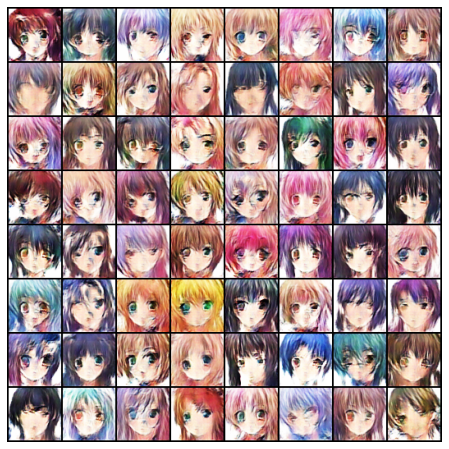

In [ ]:
#Visualising the result generated by the network
pic = plt.figure(figsize = (8, 8))
plt.axis('off')
for i in img:
  res = plt.imshow(np.transpose(i, (1, 2, 0)))